In [18]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2
from keychest.features_xy import obs_features_handcoded, arr_to_dict, dict_to_arr
from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [19]:
load_config_files(['../keychest/config/5x5_onlycoord_obs.gin'])

['5x5_onlycoord_obs']

In [25]:
h, w, c = env.engine._observation.shape

In [307]:
obss = []
env = load_env()
for _ in tqdm(range(100)):
    obs = env.reset()
    obss.append(obs)
    done = False
    while not done:
        obs, rew, done, _ = env.step(env.action_space.sample())
        obss.append(obs)

Make environment KeyChest-v0 None {}


In [308]:
f_dict = [obs_features_handcoded(env.engine, obs.reshape(h, w, c)) for obs in obss]

In [309]:
f_arr = [dict_to_arr(f) for f in f_dict]

In [310]:
len(obss), obss[0].shape

(900, (693,))

In [311]:
ds_obs = torch.from_numpy(np.array(obss)).to(torch.float32).cuda()

In [7]:
ds_obs.shape

torch.Size([900, 693])

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(693)
        self.bn2 = torch.nn.BatchNorm1d(50)
        self.fc1 = nn.Linear(in_features=693, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.bn1(x)
        x = self.act(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [9]:
decoder = Decoder().cuda()

In [10]:
opt = torch.optim.Adam(decoder.parameters(), lr=1e-3, betas=(0.8, 0.8))

In [11]:
ds_obs_orig = ds_obs.clone()

In [12]:
@gin.configurable
def siamese_feature_discriminator_l2_fake_is(obs, decoder, obs_delta_eps=1e-10,
                                     margin=1.0,
#                                      margin_same_not_farther=5.0,
                                     max_dist=500,
                                     **kwargs):
    def loss(y_true, y_pred):
        """L2 norm for the distance, no flat."""
        delta = y_true - y_pred
        delta = delta.pow(2)
        delta = delta.flatten(start_dim=1)
        delta = delta.sum(1)
        return delta

    # original inputs order
    batch_dim = obs.shape[0]

    # random permutation for incorrect inputs
    idxes = torch.randperm(batch_dim).to(obs.device)
    obs_shuffled = obs[idxes]

    idxes_orig = torch.arange(start=0, end=batch_dim).to(obs.device)
    target_close = ((obs - obs_shuffled).flatten(start_dim=1).pow(2).sum(1) <=\
                        obs_delta_eps).to(obs.device).detach()

    # distance_shuffle = loss(obs, obs_shuffled)
    decoded = decoder(obs)
    distance_f = loss(decoded, decoder(obs_shuffled))

    # print(torch.nn.ReLU()(margin - distance_f), torch.where)

#     torch.where(target_close,
# #                                 torch.nn.ReLU()(distance_f - margin_same_not_farther),
#                                 torch.nn.ReLU()(margin_different_not_closer - distance_f[~])
#                                ).mean(),
    
    loss_max_dist = torch.nn.ReLU()(distance_f - max_dist).mean()
    
    loss = torch.tensor(0.0, dtype=torch.float32).cuda()
#     loss += loss_max_dist.mean() / max_dist
    if ((~target_close).sum().item() > 0):
        loss = (torch.nn.ReLU()(margin - distance_f[~target_close])).mean() / margin
    
#     print(target_close.sum())
    
    return {'loss': loss.mean(),
            'metrics': {'distance_close': distance_f[target_close].mean().item(),
                        'distance_far': distance_f[~target_close].mean().item(),
                       'norm': decoded.abs().mean().item()}
            }

In [13]:
siamese_feature_discriminator_l2_fake_is(ds_obs, decoder)

{'loss': tensor(0.0035, device='cuda:0', grad_fn=<MeanBackward0>),
 'metrics': {'distance_close': 4.533484698754364e-12,
  'distance_far': 6.170299530029297,
  'norm': 0.44076648354530334}}

In [14]:
losses = []

In [15]:
for _ in tqdm(range(10000)):
#     idx_random = np.random.choice(len(ds_obs_orig), 10, replace=False)
#     ds_obs = ds_obs_orig[idx_random, :]
    
    opt.zero_grad()
    loss = siamese_feature_discriminator_l2_fake_is(ds_obs, decoder)['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())

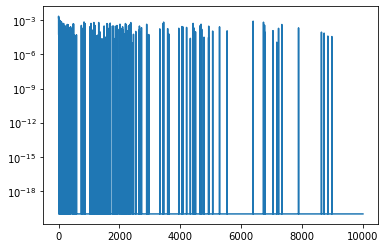

In [16]:
plt.plot(np.maximum(losses, 1e-20))
plt.yscale('log')

#### doesn't go to 0 even for this simple dataset
#### trying gan for observations...

In [29]:
decoder = Decoder().cuda()

In [33]:
class ObsFeatureDiscriminator(nn.Module):
    def __init__(self, decoder_cls):
        super(ObsFeatureDiscriminator, self).__init__()
        self.decoder = decoder_cls()
        self.fc1 = nn.Linear(in_features=2 * 10, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=1)
        self.act = nn.Tanh()
        self.bn1 = torch.nn.BatchNorm1d(20)
        self.bn2 = torch.nn.BatchNorm1d(10)
    def forward(self, obs, features):
        my_features = self.decoder(obs)
        all_f = torch.cat([my_features, features], dim=1)
        x = all_f
        x = self.bn1(x)
        x = self.act(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [34]:
disc = ObsFeatureDiscriminator(Decoder).cuda()

In [35]:
bce = torch.nn.BCEWithLogitsLoss(reduction='none')

In [36]:
opt_gen = torch.optim.Adam(decoder.parameters(), lr=1e-3)
opt_dsc = torch.optim.Adam(list(decoder.parameters()) + list(disc.parameters()), lr=1e-3,
                          betas=(0.8, 0.9))

In [37]:
def gen_loss():
    logits = disc(ds_obs, decoder(ds_obs)).view(-1)
    ans = torch.full(fill_value=True, size=(ds_obs.shape[0],)).cuda()
    loss = bce(logits, ans * 1.0) ** 2
    loss = loss.mean()
    return loss

In [38]:
gen_loss()

tensor(0.5017, device='cuda:0', grad_fn=<MeanBackward0>)

In [39]:
disc_losses = []
gen_losses = []
accs = []

In [40]:
bce1 = torch.nn.BCEWithLogitsLoss(reduction='none')
bce1(torch.randn(10), torch.full(fill_value=1.0, size=(10,)))

tensor([0.7223, 1.4211, 0.4950, 0.5386, 0.3026, 0.8030, 0.6674, 1.6039, 0.4136,
        0.7756])

In [41]:

def corr(X, eps=1e-08):
    D = X.shape[-1]
    std = torch.std(X, dim=-1).unsqueeze(-1)
    mean = torch.mean(X, dim=-1).unsqueeze(-1)
    X = (X - mean) / (std + eps)
    return 1/(D-1) * X @ X.transpose(-1, -2)


In [42]:
def disc_loss(n_perms=3):
    idxes = torch.arange(0, len(ds_obs)).cuda()
    idxes_neq = []
    perms = []
    for i in range(n_perms):
        perms.append(torch.randperm(len(ds_obs)).cuda())
        neq = perms[i] != idxes
        idxes_neq.append(neq)
    
#     print(idxes)
#     all_idx_inp = torch.cat([idxes, idxes, idxes], dim=0)
#     all_idx = torch.cat([perm2, perm3, perm1], dim=0)
#     neq = all_idx_inp != all_idx
#     all_idx = all_idx[neq]
#     all_idx_inp = all_idx_inp[neq]
#     ans_true = all_idx_inp == all_idx
#     ans_true_true = idxes == idxes

    feat = decoder(ds_obs)
    
    positive_logits = disc(ds_obs, feat).view(-1)
    pos_probas = torch.nn.Sigmoid()(positive_logits)
    negative_logits = [disc(ds_obs, decoder(ds_obs[perm, :]))
                      for perm in perms]
    
    
    neg_logits_stacked = torch.stack(negative_logits, dim=0).view(n_perms, len(ds_obs))
    neg_probas_stacked = torch.exp(neg_logits_stacked)
    neq_stacked = torch.stack(idxes_neq, dim=0)
#     print(neg_logits_stacked.shape, neq_stacked.shape, (1. * neq_stacked).mean())
    n_neg = (1. * neq_stacked).sum(0)
    
    pr_st_or_0 = torch.where(neq_stacked, neg_probas_stacked,
                             torch.zeros_like(neg_probas_stacked)).sum(0)# / n_neg
    
    
    contrastive = pos_probas / (pos_probas + pr_st_or_0)
    
    contrastive = -torch.log(contrastive)
    
#     print(corr(feat.t()).shape)
    
    contrastive += (corr(feat.t()) - torch.eye(feat.shape[1]).cuda()).flatten().pow(2).mean()
    
#     contrastive += -torch.log(pos_probas)
    
    def acc_logits(ans_bool, logits):
        return (1. * ((logits >= 0) == ans_bool)).mean()
    
#     print(contrastive)
    
#     acc = []
#     acc.append(acc_logits(idxes == idxes, positive_logits))
#     for i, ans in enumerate(idxes_neq):
#         acc.append(acc_logits(~ans, negative_logits[i]))
#     acc = sum(acc) / len(acc)
    acc = 0

    return contrastive.mean(), acc
    

#     positive
    
#     logits_true = disc(ds_obs[all_idx, :],  decoder(ds_obs[all_idx_inp, :]))
#     logits_true_true = disc(ds_obs,  decoder(ds_obs))
    
#     probas = torch.nn.Sigmoid()(logits_true).view(-1)
#     probas_true = torch.nn.Sigmoid()(logits_true_true).view(-1)
# #     disc_loss = bce(logits.view(-1), 1. * ans_true)# ** 2
# #     disc_loss = disc_loss.mean()
#     def margin(probas):
#         return 2 * (probas - 0.5)
    
#     marg = 1.0 - logits_true.view(-1) * margin(ans_true * 1.0)
#     marg_true = 1.0 - logits_true_true.view(-1) * margin(ans_true_true * 1.0)
# #     print(logits, logits.view(-1) * margin(ans_true * 1.0))
# #     print(marg.min())
    
#     disc_loss_true = torch.nn.ReLU()(marg).mean(0)
#     disc_loss_true_true = torch.nn.ReLU()(marg_true).mean(0)
    
#     disc_loss = (disc_loss_true_true + disc_loss_true) / 2
# #     disc_loss = torch.abs(torch.nn.Sigmoid()(logits).view(-1) - 1. * ans_true).mean()
# #     acc = (1. * ((torch.nn.Sigmoid()(logits) > 0.5) == ans_true)).mean()
# #     return disc_loss, acc
# #     disc_loss = torch.pow(probas - (1. * ans_true), 2).mean()
#     acc_true = (1. * ((logits_true >= 0) == ans_true)).abs().mean()
#     acc_true_true = (1. * ((logits_true_true >= 0) == ans_true_true)).abs().mean()
#     acc = (acc_true + acc_true_true) / 2
#     return disc_loss, acc

In [43]:
disc_loss()

(tensor(2.1177, device='cuda:0', grad_fn=<MeanBackward0>), 0)

In [44]:
corr(torch.randn(1000, 100))

tensor([[ 1.0000e+00, -8.3440e-03,  9.5791e-02,  ..., -1.3557e-01,
          7.0304e-02, -2.8891e-02],
        [-8.3440e-03,  1.0000e+00,  9.6498e-02,  ...,  1.2805e-01,
         -4.0995e-02,  1.2795e-01],
        [ 9.5791e-02,  9.6498e-02,  1.0000e+00,  ..., -1.8107e-03,
          1.5173e-02, -8.7416e-03],
        ...,
        [-1.3557e-01,  1.2805e-01, -1.8107e-03,  ...,  1.0000e+00,
          4.3871e-04,  3.0930e-02],
        [ 7.0304e-02, -4.0995e-02,  1.5173e-02,  ...,  4.3872e-04,
          1.0000e+00,  1.0063e-01],
        [-2.8891e-02,  1.2795e-01, -8.7416e-03,  ...,  3.0930e-02,
          1.0063e-01,  1.0000e+00]])

In [47]:
for i in tqdm(range(10000)):
    
#     idx_random = np.random.choice(len(ds_obs_orig), 10, replace=False)
#     ds_obs = ds_obs_orig[idx_random, :]
    ds_obs = ds_obs_orig
    
    opt_dsc.zero_grad()
    loss_dsc,acc = disc_loss()
    loss_dsc.backward()
    opt_dsc.step()
    
#     opt_gen.zero_grad()
#     loss_gen = gen_loss()
#     loss_gen.backward()
#     opt_gen.step()
    
    disc_losses.append(loss_dsc.item())
#     gen_losses.append(loss_gen.item())
    accs.append(acc)

KeyboardInterrupt: 

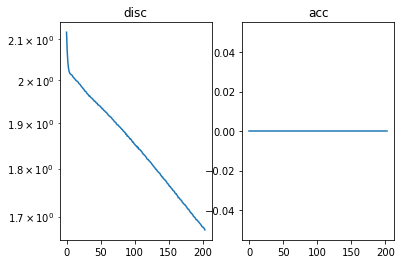

In [48]:
plt.subplot(1, 2, 1)
plt.title('disc')
plt.plot(disc_losses)
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.title('acc')
plt.plot(accs)

In [49]:
ds_obs.shape

torch.Size([900, 693])

In [50]:
acc

0

In [51]:
df = pd.DataFrame(decoder(ds_obs).detach().cpu().numpy())

In [52]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,-0.035047,0.127900,0.055749,0.053833,-0.034476,-0.032898,0.002676,-0.004913,0.012392,0.119765
std,0.814115,0.739854,0.580515,0.714924,0.681313,0.776820,0.754991,0.720216,0.678483,0.794850
min,-2.107828,-4.673901,-2.645548,-3.143298,-7.289146,-2.371760,-7.494442,-2.960361,-8.269010,-6.995948
25%,-0.492486,-0.183112,-0.241785,-0.411490,-0.266399,-0.510400,-0.456141,-0.391561,-0.301809,-0.352702
50%,-0.053519,0.140866,0.035246,0.090243,-0.054656,-0.055814,-0.022096,-0.029116,0.033047,0.106515
75%,0.317883,0.456187,0.292842,0.466489,0.159029,0.405714,0.467848,0.411322,0.359689,0.568101
max,5.416821,6.593935,4.667097,4.173872,7.371929,5.016850,3.436746,9.328987,3.113094,4.445553


In [53]:
sns.heatmap(pd.concat([pd.DataFrame(dataset_features), df], axis=1).corr())

NameError: name 'dataset_features' is not defined

In [54]:
plt.scatter(df[3], dataset_features[:, 0])# - dataset_features[:, 1])

NameError: name 'dataset_features' is not defined

In [55]:
plt.scatter(df[1], dataset_features[:, 0] - dataset_features[:, 1])

NameError: name 'dataset_features' is not defined

# GAN and a reconstructor

In [753]:
bce = torch.nn.BCEWithLogitsLoss(reduction='none')

In [754]:
decoder = Decoder().cuda()

In [755]:
class Reconstructor(nn.Module):
    def __init__(self):
        super(Reconstructor, self).__init__()
        self.fc1 = nn.Linear(in_features=10, out_features=693)
        self.fc2 = nn.Linear(in_features=693, out_features=693)
        self.act = nn.Tanh()
        self.bn1 = torch.nn.BatchNorm1d(10)
        self.bn2 = torch.nn.BatchNorm1d(693)
    def forward(self, x):
        x = self.bn1(x)
        x = self.act(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x
rec = Reconstructor().cuda()

In [756]:
class ReconstructedDiscriminator(nn.Module):
    def __init__(self, decoder_cls):
        super(ReconstructedDiscriminator, self).__init__()
        self.decoder1 = decoder_cls()
#         self.decoder2 = decoder_cls()
        self.fc1 = nn.Linear(in_features=693, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=1)
        self.act = nn.Tanh()
        self.bn = torch.nn.BatchNorm1d(100)
    def forward(self, obs_1):#, obs_2):
#         z = (obs_1 - obs_2).pow(2)
        z = obs_1# - obs2
#         z = self.bn(z)
#         f1 = self.decoder1(z)
#         f2 = self.decoder1(obs_2)
#         all_f = f1 - f2
        all_f = z#f1
#         f2 = self.decoder1(obs_2)
#         all_f = torch.cat([f1, f2], dim=1)
#         all_f = f1
        x = all_f
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

In [757]:
disc = ReconstructedDiscriminator(Decoder).cuda()

In [758]:
torch.max(torch.tensor([1.0, 2.0]), torch.tensor([3.0, 4.0]))

tensor([3., 4.])

In [759]:
def disc_loss():
    logits_true = disc(ds_obs)#, torch.zeros_like(ds_obs))
    probas_true = torch.nn.Sigmoid()(logits_true).view(-1)
    ans_true = torch.full(fill_value=True, size=(ds_obs.shape[0],)).cuda()
    disc_loss_true = bce(logits_true.view(-1), 1. * ans_true).mean()
    acc_true = (1. * ((probas_true >= 0.5) == ans_true)).abs().mean()
    
    logits_false = disc(rec(decoder(ds_obs))) # torch.zeros_like(ds_obs)
    probas_false = torch.nn.Sigmoid()(logits_false).view(-1)
    ans_false = torch.full(fill_value=False, size=(ds_obs.shape[0],)).cuda()
    disc_loss_false = bce(logits_false.view(-1), 1. * ans_false).mean()
    acc_false = (1. * ((probas_false >= 0.5) == ans_false)).abs().mean()
    
    return (disc_loss_true + disc_loss_false) / 2, (acc_true + acc_false) / 2

def gen_loss():
    logits_false = disc(rec(decoder(ds_obs))) # torch.zeros_like(ds_obs)
    probas_false = torch.nn.Sigmoid()(logits_false).view(-1)
    ans_false = torch.full(fill_value=True, size=(ds_obs.shape[0],)).cuda()
    disc_loss_false = bce(logits_false.view(-1), 1. * ans_false).mean()
    acc_false = (1. * ((probas_false >= 0.5) == ans_false)).abs().mean()
    
    return disc_loss_false, acc_false

def gen_loss_l2():
    ds_rec_obs = rec(decoder(ds_obs))
    delta = ds_obs - ds_rec_obs
    delta = delta.pow(2).sum(1).mean()
    return delta

def gen_loss_l2_relative(eps=1e-6):
    ds_rec_obs = rec(decoder(ds_obs))
    delta = ds_obs - ds_rec_obs
#     delta_magnitude = torch.max(ds_obs.abs(), ds_rec_obs.abs())
#     delta_magnitude = ds_obs.abs()
#     delta_magnitude = torch.max(delta_magnitude, delta.abs())
#     delta_magnitude = delta_magnitude# + eps
    delta_magnitude = ds_obs.std(0).unsqueeze(0)
    
#     cond = delta_magnitude.repeat(ds_obs.shape[0],
#                                                1) < eps
    
#     delta = torch.where(cond,
#                         torch.zeros_like(delta), delta)
    
#     delta_magnitude = torch.where(cond,
#                                  torch.ones_like(delta_magnitude),
#                                  delta_magnitude)
    
    delta_magnitude = torch.where(delta_magnitude < eps,
                                  torch.ones_like(delta_magnitude),
                                  delta_magnitude)
    
    delta_orig = delta
    delta = delta / delta_magnitude
    
#     print(delta_magnitude)
    
#     is_good = (~torch.isinf(delta)) & (~torch.isnan(delta))
    
#     delta = torch.where(is_good, delta, torch.zeros_like(delta))
#     print(delta)
#     print(is_good)
    delta = delta.pow(2).sum(1).mean()# + delta_orig.pow(2).sum(1).mean()
    return delta

In [760]:
?(torch.repeat)

Object `(torch.repeat)` not found.


In [761]:
ds_rec_obs = rec(decoder(ds_obs))
delta = ds_obs - ds_rec_obs
eps=1e-8
delta_magnitude = torch.max(ds_obs.abs(), ds_rec_obs.abs()) + eps

In [762]:
gen_loss_l2_relative()

tensor(2173.7434, device='cuda:0', grad_fn=<MeanBackward0>)

In [763]:
class VarianceLossLRDecay():
    """If the variance is lower than the improvement by a factor, decrease the lr.
    
    When reached minimal learning rate, reset to default one and reset the optimizer."""
    def __init__(self, optimizer, factor_lr_decrease=0.5,
                 grace_epochs=1000,
                 var_factor=5,
                 min_lr=1e-6,
                 default_lr=1e-3,
                 rolling_epochs=100):
        self.optimizer = optimizer
        self.factor_lr_decrease = factor_lr_decrease
        self.grace_epochs = grace_epochs
        self.rolling_epochs = rolling_epochs
        self.var_factor = var_factor
        self.min_lr = min_lr
        self.default_lr = default_lr
        self.reset()
        
    def set_lr(self, lr):
        self.lr = lr
        for g in self.optimizer.param_groups:
            g['lr'] = self.lr
        
    def reset(self):
        self.epochs = 0
        self.loss_history = []
        self.set_lr(self.default_lr)
        
    def step(self, loss_value):
        if hasattr(loss_value, 'item'):
            loss_value = loss_value.item()
        self.loss_history.append(loss_value)
        self.epochs += 1
        
        if len(self.loss_history) >= self.grace_epochs + self.rolling_epochs and (self.epochs % self.grace_epochs) == 0:
            smoothed_loss = pd.Series(self.loss_history).rolling(self.rolling_epochs).median()
#             print("smoothed len", len(smoothed_loss))
            smoothed_loss = list(smoothed_loss)
            smoothed_loss_then = smoothed_loss[-self.grace_epochs]
            smoothed_loss_now = smoothed_loss[-1]
            
            # example: then=1, now=-1 -> improvement = 2/1=2
            absolute_improvement = (smoothed_loss_then - smoothed_loss_now)# / smoothed_loss_then
            loss_std = np.abs(np.std(self.loss_history[-self.grace_epochs:]) - np.std(smoothed_loss[-self.grace_epochs:]))
            
            print(f"Epoch {self.epochs} abs improvement {absolute_improvement} {loss_std}")
            
#             if relative_improvement < self.factor_loss_relative:
            if absolute_improvement < loss_std * self.var_factor:
                self.set_lr(self.lr * self.factor_lr_decrease)
                print(f'Decreasing lr...')
                
        if self.lr < self.min_lr:
            self.reset()

In [764]:
disc_loss(), gen_loss(), gen_loss_l2()

((tensor(0.6989, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6461, device='cuda:0')),
 (tensor(0.6716, device='cuda:0', grad_fn=<MeanBackward0>),
  tensor(0.6122, device='cuda:0')),
 tensor(291.0066, device='cuda:0', grad_fn=<MeanBackward0>))

In [765]:
opt_disc = torch.optim.Adam(disc.parameters(), lr=1e-3)
opt_l2 = torch.optim.Adam(list(decoder.parameters()) + list(rec.parameters()), lr=1e-4)
opt_rec = torch.optim.Adam(list(decoder.parameters()) + list(rec.parameters()), lr=1e-3)

In [766]:
sch_disc = VarianceLossLRDecay(opt_disc)
sch_l2 = VarianceLossLRDecay(opt_l2)
sch_rec = VarianceLossLRDecay(opt_rec)

In [767]:
acc_gens = []
acc_discs = []
loss_gens = []
loss_discs = []
loss_l2s = []

In [783]:
for i in tqdm(range(10000)):
#     opt_l2.zero_grad()
#     loss =  gl2
#     loss.backward()
#     sch_l2.step(loss.item())
#     opt_l2.step()
    
    opt_rec.zero_grad()
    gl2 = gen_loss_l2_relative()
#     gl, acc_gen = gen_loss()
    loss =  gl2 # + gl / 100.
    loss.backward()
    sch_rec.step(loss.item())
    opt_rec.step()
    
    reconstructed = rec(decoder(ds_obs))
    acc_gen = (1. * (reconstructed > 0.5) - ds_obs).abs().mean()
    
    opt_disc.zero_grad()
    dl, acc_dsc = disc_loss()
    loss = dl
    loss.backward()
    sch_disc.step(loss.item())
    opt_disc.step()
    
    acc_gens.append(acc_gen.item())
    acc_discs.append(acc_dsc.item())
    loss_gens.append(gl.item())
    loss_discs.append(dl.item())
    loss_l2s.append(gl2.item())

Epoch 8000 abs improvement 0.39166170358657837 0.029818070104817115
Epoch 8000 abs improvement -0.04420876502990723 0.0014353519661439613
Decreasing lr...



KeyboardInterrupt: 

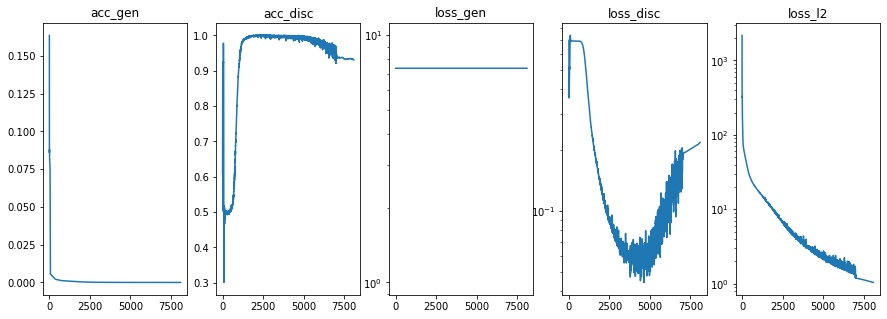

In [784]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.plot(acc_gens)
plt.title('acc_gen')

plt.subplot(1, 5, 2)
plt.plot(acc_discs)
plt.title('acc_disc')

plt.subplot(1, 5, 3)
plt.plot(loss_gens)
plt.title('loss_gen')
plt.yscale('log')

plt.subplot(1, 5, 4)
plt.plot(loss_discs)
plt.title('loss_disc')
plt.yscale('log')

plt.subplot(1, 5, 5)
plt.plot(loss_l2s)
plt.title('loss_l2')
plt.yscale('log')

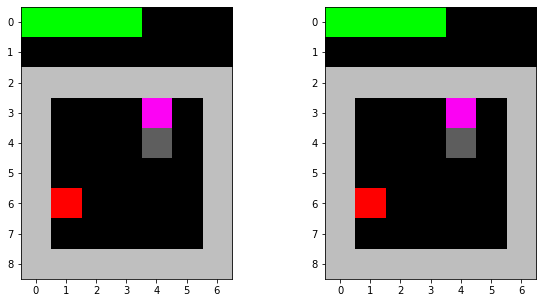

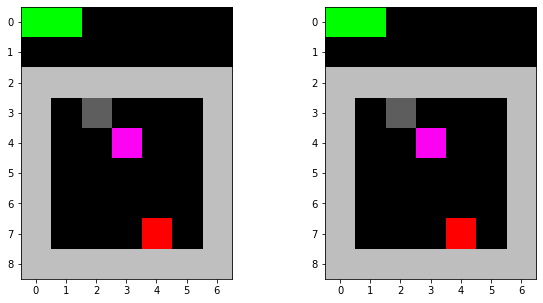

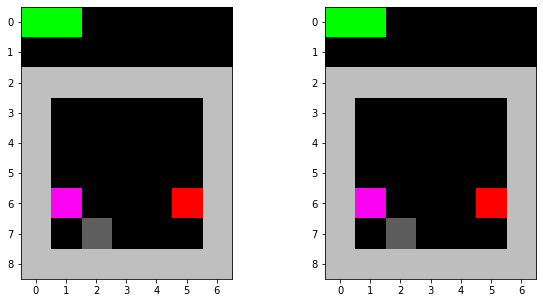

In [786]:
reconstructed = rec(decoder(ds_obs))
from keychest.keychestenv import obss_to_rgb

for _ in range(3):
    idx = np.random.choice(len(ds_obs))
    r = reconstructed[idx]
    orig = ds_obs[idx]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(obss_to_rgb(orig.reshape(1, h, w, c).detach().cpu(),
                           env.engine, ignore_empty=True)[0])
    plt.subplot(1, 2, 2)
    plt.imshow(obss_to_rgb((r>0.5).reshape(1, h, w, c).detach().cpu(),
                           env.engine, ignore_empty=True)[0])
    plt.show()

In [ ]:
(1. * (reconstructed > 0.5) - ds_obs).abs().mean()

In [1]:
import pickle

In [3]:
fn = """

/home/sergei/ray_results/5x5_onlycoord_obs_kc_simple_reconstruction_server_collect/main_fcn_2706c_00000_0_2021-02-17_14-15-06/checkpoint_1000/checkpoint

""".strip()

In [4]:
l = pickle.load(open(fn, 'rb'))

Selecting name 678ecf2a-7125-11eb-91aa-a38a96b0feb0


2021-02-17 14:38:23,802	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


Make environment KeyChest-v0 None {}


(pid=32424) Make environment KeyChest-v0 None {}


ERROR:root:Cannot collect data Use collect_and_get_context


In [5]:
ctx = l.collect_and_get_context()

In [6]:
ox = ctx['obs_x']

In [7]:
(l.reconstructor(l.decoder(ox)) - ox).pow(2).sum(1).mean(0)

tensor(5.5584, device='cuda:0', grad_fn=<MeanBackward1>)

In [23]:
import torch
from matplotlib import pyplot as plt

In [9]:
ox_dec = l.reconstructor(l.decoder(ox))

In [10]:
def thr_half(tensor):
    """Get the middle between min/max over batch dimension."""
    m = tensor.min(0, keepdim=True).values
    M = tensor.max(0, keepdim=True).values
    return m, (M - m) / 2.0
    
def delta_01_obs(obs, rec_dec_obs):
    """Compute accuracy between observations and reconstructed observations."""
    m1, d1 = thr_half(obs)
    thr1 = m1 + d1
    
    m2, d2 = thr_half(rec_dec_obs)
    thr2 = m2 + d2
    
    delta_01 = 1. * ((obs > thr1) == (rec_dec_obs > thr2))
    delta_01 = torch.where(d1.repeat(obs.shape[0], 1) != 0,
                           delta_01, torch.ones_like(delta_01))
    delta_01_agg = delta_01.mean(1).mean(0)
    return delta_01_agg


In [11]:
delta_01_obs(ox, ox_dec)

tensor(0.9995, device='cuda:0')

In [12]:
obs = ox
rec_dec_obs = ox_dec

m1, d1 = thr_half(obs)
thr1 = m1 + d1

m2, d2 = thr_half(rec_dec_obs)
thr2 = m2 + d2

delta_01 = 1. * ((obs > thr1) == (rec_dec_obs > thr2))
delta_01 = torch.where(d1.repeat(obs.shape[0], 1) != 0,
                       delta_01, torch.ones_like(delta_01))

In [20]:
h, w, c = l.env.engine._observation.shape

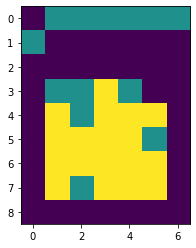

In [25]:
plt.imshow((delta_01.mean(0) < 1).detach().cpu().numpy().reshape(h, w, c).mean(axis=2))